In [409]:
import pandas as pd
import numpy as np
from pathlib import Path
base_path = Path('/home/Greggy/ml wakacyjne wyzwanie/ml-wakacyjne-wyzwanie-2025/1_przetwarzanie_wizualizacja') # change path here!

In [410]:
import matplotlib.pyplot as plt
import seaborn as sns

# Klasyfikacja pasażerów Titanica
Po wysłaniu raportu pozostało już tylko czekać. Dni mijały, ale w końcu telefon zadzwonił. Okazało się, że po konsultacji Twojego raportu z najbardziej doświadczonymi specjalistami w dziedzinie, zleceniodawca zdecydował się powierzyć Ci dalszą część tajemniczego zadania. Chodzi oczywiście o... **stworzenie modelu przewidującego szanse przeżycia katastrofy Titanica**.

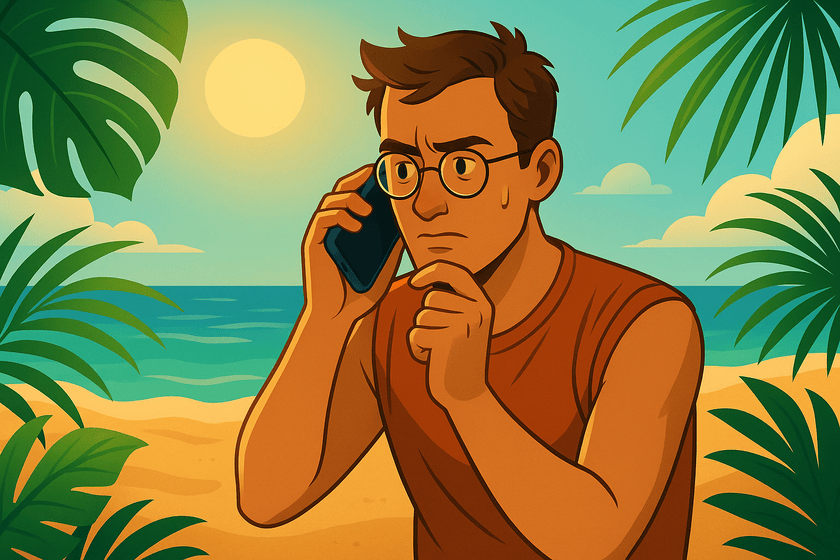

(*AI-generated image*)


#### Twoim celem będzie jest wytrenowanie modeli do klasyfikacji każdego pasażera Titanica jako ofiary (0) lub osoby, która przeżyła (1).

Poniżej znajdziesz pytania, które mogą być pomocne w zadaniu:

- Czego nauczyło Cię o badanym zbiorze danych poprzednie zadanie? Jak możesz wykorzystać wyciągnięte z niego wnioski w procesie tworzenia modelu?
- Jak przeprowadzenie standaryzacji danych może wpływać na zachowanie modelu?
- Co mój model robi i w jaki sposób?
- Jak nie przetrenować wybranego modelu?
- Jaki wynik klasyfikacji możemy uznać za *dobry*?


Wymagania:
- Wypisz obserwacje z pierwszego zadania, które pomogą Ci w tym. Co było przydatne, a co okazało się bezużyteczne?
- [Nie doprowadź](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) do ~~przecieku statku~~ wycieku danych (np. nie ucz modelu na danych testowych). Nauczone modele odpal na danych treningowych i testowych - opisz uzyskane wyniki.
- Stwórz baseline, czyli dla porównania sprawdź jak z zadaniem radzi sobie [Dummy Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) (jeśli Twój docelowy model radzi sobie gorzej - uciekaj)
- Przeprowadź badania na dwóch wybranych modelach uczenia maszynowego (np. spośród: drzew decyzyjnych, SVM, MLP, KNN, z gwiazdką [XGBoost](https://xgboost.readthedocs.io/en/stable))
- W badaniach użyj wybranych metryk. Wybór uzasadnij.
- Dla każdego modelu wybierz co najmniej dwa hiperparametry i przeprowadź badania zależności wyników metryk od wartości hiperparametrów. Zwizualizuj wszystko ładnie, zastanów się dlaczego tak mogło być i wyciągnij i wypisz wnioski.
- Podsumuj przeprowadzone badania, wypisz wnioski.

Niezmiennie, zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

Jeśli chcesz, możesz sprawdzić (przyjmując pewne założenia), jakie byłyby Twoje szanse na Titanicu.

Uwaga! Jeśli Titanic to dla Ciebie nic i baaaaardzo chcesz to możesz w ramach tego zadania zająć się [bardziej wymagającym](https://archive.ics.uci.edu/dataset/365/polish+companies+bankruptcy+data) zbiorem.

In [411]:
titanic_df = pd.read_csv(base_path / 'titanic.csv', index_col='PassengerId')

In [412]:
titanic_df['Cabin'].str[0].unique()

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

# Obserwacje z zadania 1

Po uzupełnieniu pola Age i Fare średnią powstały wysokie sztuczne szczyty, więc tym razem trochę to uzależniłem od innych kolumn, aby trochę to zmniejsyć.

Grupa Age 18-60 ma >80% wystąpień, przez co nie rozróżnia tak dobrze wierszy. Tym razem rozbijam to na 0-20-30-100

Kolumna z informacją czy ktoś jest z dużą ilością dzieci miałą wartość True ma tylko 15 wystąpień, co było zbyt mało, żeby w jakiś znaczący sposób algorytm mógł wyłapać zależność z innymi zmiennymi. Tym razem zsumowałem Parch i SibSp jako FamilySize i zostawiłem tylko IsAlone, gdy ktoś jest całkowicie sam.


Kolumnę z informacją czy ktoś jest bogaty można połączyć z informacją o porcie, bo dla każdego portu rozkłady były różne, więc też bycie bogatym może być subiektywne.

# Podział na zbiór treningowy i testowy

In [413]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import DecisionBoundaryDisplay
X, y = load_iris(return_X_y=True)

In [414]:
y = titanic_df['Survived']
X = titanic_df.drop('Survived', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Uzupełnienie braków

In [415]:
def preprocess_data(df):
    df.convert_dtypes()

    df['Fare'] = df.groupby('Pclass')['Fare'].transform(lambda x: x.fillna(x.median()))
    df['Age'] = df.groupby(['Pclass', 'Sex'])['Age'].transform(lambda x: x.fillna(x.median()))
    df = df.fillna({"Embarked": "S"})

    df.drop(['Cabin','Name', 'Ticket'], axis=1, inplace=True)

    df['FamilySize'] = df['SibSp'] + df['Parch']
    df['IsAlone'] = (df['FamilySize'] == 0).astype(int)
    df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 20, 30, 100], labels=['Child', 'Adult', 'OlderThan30'])
    df['IsRichInRegion'] = df.groupby('Embarked')['Fare'].transform(lambda x: x > x.median()).astype(int)

    df['Sex'] = df['Sex'].map({
        'male': 1, 'female': 0
    })
    df['AgeGroup'] = df['AgeGroup'].map({
        'Child': 0, 'Adult': 1, 'OlderThan30': 2
    })
    df = pd.get_dummies(data=df, prefix='Embarked', columns=['Embarked'], dtype=np.int32)

    return df



In [416]:
X_train = preprocess_data(X_train)
X_test = preprocess_data(X_test)

In [417]:
def print_after_preprocessing(df):
    print("After preprocessing:")
    print("\nIs null sum: ")
    print(df.isnull().sum())
    print("\nIs Alone value counts: ")
    print(df['IsAlone'].value_counts())
    print("\nAge Group value counts: ")
    print(df['AgeGroup'].value_counts())
    print("\nIs Rich In Region value counts: ")
    print(df['IsRichInRegion'].value_counts())
    print("\nEmbarked C value counts: ")
    print(df['Embarked_C'].value_counts())
    print("\nEmbarked Q value counts: ")
    print(df['Embarked_Q'].value_counts())
    print("\nEmbarked S value counts: ")
    print(df['Embarked_S'].value_counts())
    print("\nSex value counts: ")
    print(df['Sex'].value_counts())
    print(df.head(n=10))


In [418]:
print_after_preprocessing(X_train)

After preprocessing:

Is null sum: 
Pclass            0
Sex               0
Age               0
SibSp             0
Parch             0
Fare              0
FamilySize        0
IsAlone           0
AgeGroup          0
IsRichInRegion    0
Embarked_C        0
Embarked_Q        0
Embarked_S        0
dtype: int64

Is Alone value counts: 
IsAlone
1    429
0    283
Name: count, dtype: int64

Age Group value counts: 
AgeGroup
1    309
2    261
0    142
Name: count, dtype: int64

Is Rich In Region value counts: 
IsRichInRegion
0    365
1    347
Name: count, dtype: int64

Embarked C value counts: 
Embarked_C
0    587
1    125
Name: count, dtype: int64

Embarked Q value counts: 
Embarked_Q
0    652
1     60
Name: count, dtype: int64

Embarked S value counts: 
Embarked_S
1    527
0    185
Name: count, dtype: int64

Sex value counts: 
Sex
1    467
0    245
Name: count, dtype: int64
             Pclass  Sex   Age  SibSp  Parch      Fare  FamilySize  IsAlone  \
PassengerId                             

In [419]:
print_after_preprocessing(X_test)

After preprocessing:

Is null sum: 
Pclass            0
Sex               0
Age               0
SibSp             0
Parch             0
Fare              0
FamilySize        0
IsAlone           0
AgeGroup          0
IsRichInRegion    0
Embarked_C        0
Embarked_Q        0
Embarked_S        0
dtype: int64

Is Alone value counts: 
IsAlone
1    108
0     71
Name: count, dtype: int64

Age Group value counts: 
AgeGroup
2    75
1    58
0    46
Name: count, dtype: int64

Is Rich In Region value counts: 
IsRichInRegion
0    95
1    84
Name: count, dtype: int64

Embarked C value counts: 
Embarked_C
0    136
1     43
Name: count, dtype: int64

Embarked Q value counts: 
Embarked_Q
0    162
1     17
Name: count, dtype: int64

Embarked S value counts: 
Embarked_S
1    119
0     60
Name: count, dtype: int64

Sex value counts: 
Sex
1    110
0     69
Name: count, dtype: int64
             Pclass  Sex   Age  SibSp  Parch     Fare  FamilySize  IsAlone  \
PassengerId                                   

# Analiza modeli

In [420]:
def plot_confusion_matrix(y_test, y_pred, model):
    conmat = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conmat, display_labels=model.classes_)
    disp.plot(cmap="Accent")
    plt.title(f"{model} - Titanic")
    plt.show()

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))


In [421]:
def test_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    plot_confusion_matrix(y_test, y_pred, model)


Przetestujemy różne modele klasyfikacji, aby zobaczyć, który z nich najlepiej radzi sobie z danymi.

## DummyClassifier

Na początek użyjemy DummyClassifier, aby później wiedzieć kiedy uciekać.

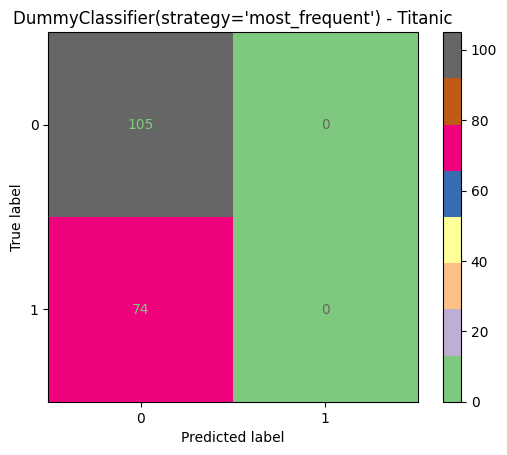

Accuracy: 0.5865921787709497

Classification Report:
               precision    recall  f1-score   support

           0       0.59      1.00      0.74       105
           1       0.00      0.00      0.00        74

    accuracy                           0.59       179
   macro avg       0.29      0.50      0.37       179
weighted avg       0.34      0.59      0.43       179



/home/Greggy/ml wakacyjne wyzwanie/ml-wakacyjne-wyzwanie-2025/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/Greggy/ml wakacyjne wyzwanie/ml-wakacyjne-wyzwanie-2025/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/Greggy/ml wakacyjne wyzwanie/ml-wakacyjne-wyzwanie-2025/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

In [422]:
test_model(DummyClassifier(strategy="most_frequent"))

Zatem misja: mieć dokładność co najmniej 60%

## DecisionTreeClassifier

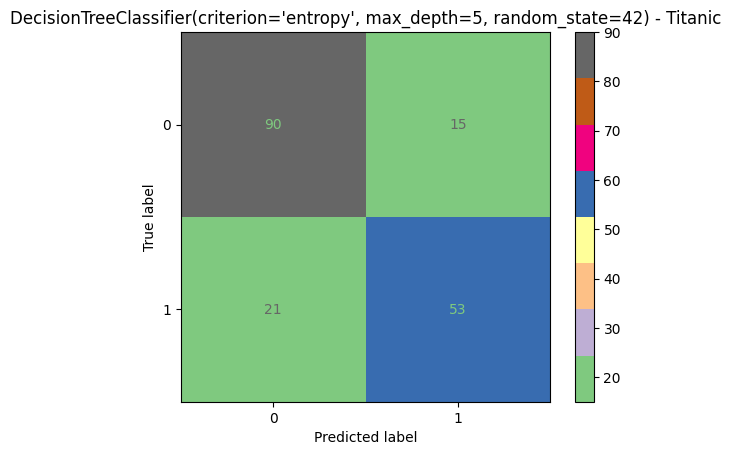

Accuracy: 0.7988826815642458

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.86      0.83       105
           1       0.78      0.72      0.75        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



In [423]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)
test_model(tree)

Dobra, póki co bezpiecznie, jesteśmy daleko od tragedii, ale nie jest też idealnie, osiągnęliśmy 80%.

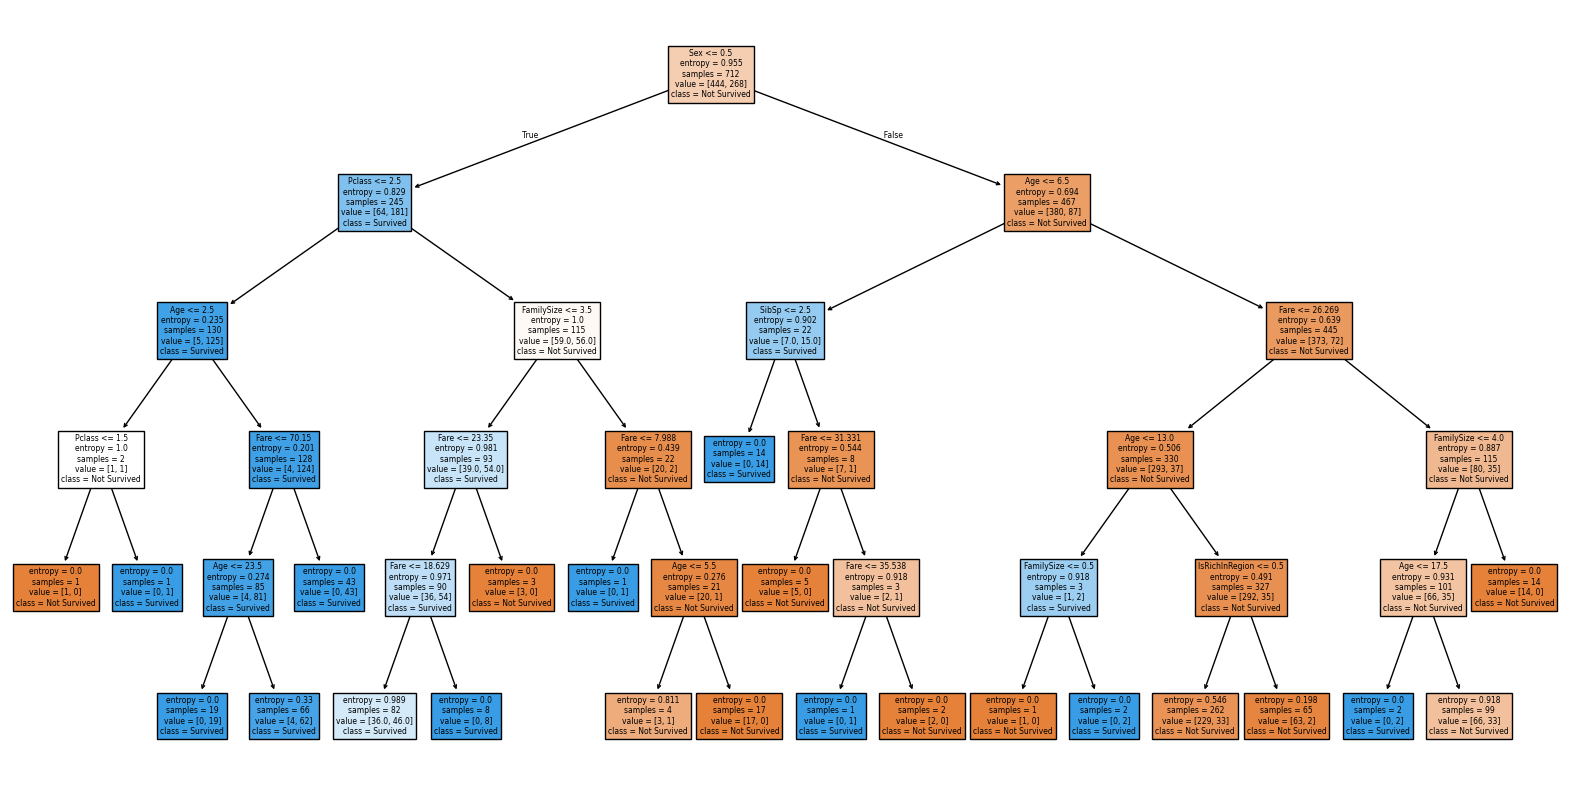

In [424]:
plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=X_test.columns, class_names=['Not Survived', 'Survived'], filled=True)
plt.show()

Wyszło takie drewo

# KNN

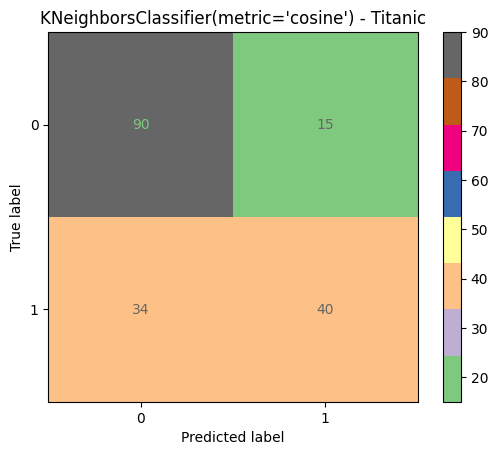

Accuracy: 0.7262569832402235

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.86      0.79       105
           1       0.73      0.54      0.62        74

    accuracy                           0.73       179
   macro avg       0.73      0.70      0.70       179
weighted avg       0.73      0.73      0.72       179



ValueError: n_features must be equal to 2. Got 13 instead.

In [425]:
knn = KNeighborsClassifier(n_neighbors=5, metric='cosine')
test_model(knn)

DecisionBoundaryDisplay.from_estimator(knn, X_test, response_method="predict", alpha=0.3)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='coolwarm', edgecolor='k')
plt.title("KNN z cosine similarity (k=5)")
plt.xlabel("Cecha 1")
plt.ylabel("Cecha 2")
plt.grid(True)
plt.show()